In [19]:
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [20]:
forecast = pd.read_csv("data/test_forecast_long.csv")
forecast = forecast[forecast['ds'] >= '2021-01-04']
forecast["timestamp"] = forecast["ds"]

cutoff_ts = forecast['ds'].min()


In [21]:
# Fetch forwards data for the same date range as the forecast
forwards = filter_independent(get_forwards(
    timestamp=cutoff_ts,
    start=forecast["timestamp"].min(),
    end="2023-01-01"
))

#forwards

In [22]:
t, F = partition_forwards(forwards, pd.to_datetime(cutoff_ts, utc=True)-pd.Timedelta(1, 'h'))

In [23]:
# Construct matrices
H = construct_H(t)

In [24]:
s_t = np.array(forecast["yhat"])
A, b = construct_A_and_b(t, F, s_t)


In [25]:
# Solve the system
x, lam = solve_linear_system(H, A, b)

# Results
print("Solution x:", x)

Solution x: [-3.03242002e-06  9.95816941e-16 -9.24029372e-15  3.63451603e-01
  8.14864009e+00  1.16329866e-05 -1.40787903e-03  5.06836452e-02
 -4.47486721e-01  1.30142700e+01 -1.78424907e-05  4.25141261e-03
 -3.56785353e-01  1.25915212e+01 -1.43453825e+02  1.06335405e-05
 -3.94968440e-03  5.28933124e-01 -2.99229657e+01  6.21806939e+02
  3.49898072e-06 -1.21001342e-03  1.34420503e-01 -4.67415797e+00
  1.58355542e+01 -7.88639297e-06  4.25496595e-03 -8.49275783e-01
  7.40215450e+01 -2.34503553e+03  3.15225548e-06 -2.10329556e-03
  5.24108703e-01 -5.78233657e+01  2.40138125e+03 -2.81570056e-08
  3.39416290e-05 -1.44750692e-02  2.49801677e+00 -1.32116814e+02
  7.30890138e-09 -1.37245500e-05  9.54868501e-03 -2.88330417e+00
  3.19914146e+02 -2.47409762e-09  5.99797602e-06 -5.36154464e-03
  2.12653299e+00 -3.11325337e+02  1.19931652e-09 -3.87616119e-06
  4.59158567e-03 -2.33246939e+00  4.37787063e+02 -8.04560884e-11
  4.23874767e-07 -8.26459639e-04  7.01635981e-01 -1.99375065e+02
  1.63298912e

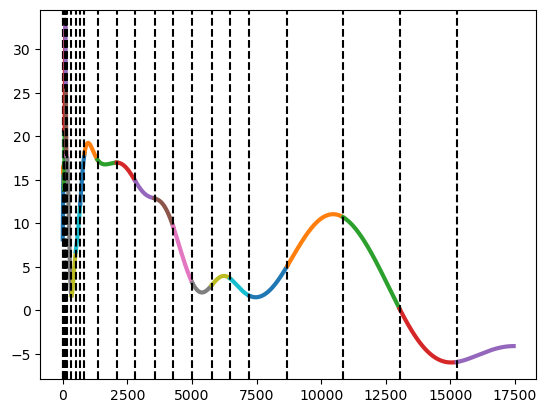

In [26]:
#print correction term epsilon
for k in range(len(t)-1):
    plt.plot(range(t[k],t[k+1],1),[epsilon(x,t,i) for i in range(t[k],t[k+1],1)],lw=3)
    #plot dotted vertical lines at t[k]
    plt.axvline(x=t[k], color='k', linestyle='--')

In [27]:
epsilon_values = [epsilon(x, t, i) for i, _ in enumerate(forecast["yhat"])]
initial_yhat = forecast["yhat"]
forecast["corrected"] = forecast["yhat"] + epsilon_values

fig = plot_forecast_forwards("2021-01-04", forecast, forwards)

# Add intial as a dashed red line
fig.add_trace(go.Scatter(
    x=forecast["timestamp"],
    y=forecast["corrected"],
    mode='lines',
    name='PFC',
    line=dict(color='red')
))

# Add the correction area as a transparent red fill
fig.add_trace(go.Scatter(
    x=pd.concat([forecast["timestamp"], forecast["timestamp"][::-1]]),
    y=pd.concat([initial_yhat, forecast["corrected"][::-1]]),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.2)',  # Transparent red
    line=dict(color='rgba(255, 0, 0, 0)'),
    name='arbitrage correction \u03b5(t)'
))
